In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neural_network import MLPClassifier as NN

import math
import matplotlib as mpl
from functools import partial

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF

from dijsktra_algorithm import Graph, dijsktra_toall
from density_estimator import DensityEstimator


In [2]:
# https://www.python-course.eu/neural_network_mnist.php
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "/Users/rafaelpoyiadzi/Documents/mnist_train.csv"
train_data = np.loadtxt(data_path, delimiter=",")


fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
train_labels = np.asfarray(train_data[:, :1]).ravel()


In [4]:
indices0 = set(np.where(train_labels == 0)[0][:1000])
indices8 = set(np.where(train_labels == 8)[0][:1000])


indices = np.array(list(indices0.union(indices8)))

X = train_imgs[indices, :]
y = train_labels[indices]

y[y==0]=0
y[y==8]=1

In [5]:
def inv_log(x):
    return -np.log(x)

def get_edges(kernel):
    edges = []

    n_samples = kernel.shape[0]
    for i in range(n_samples):
        for j in range(i):
            weight = kernel[i, j]
            if weight != 0 :
                edges.append([i, j, weight])
                #edges.append([str(j), str(i), weight])
    return edges


def get_weights(X, 
                density_scorer, 
                mode,
                weight_func = inv_log):
    epsilon = 0.75
    n_samples, _ = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                midpoint = (v0 + v1)/2
                density = density_scorer(midpoint.reshape(1, -1))
                if mode == 1:
                    k[i, j] = weight_func(np.exp(density)) * dist
                else:
                    k[i, j] = weight_func(sigmoid(density)) * dist
            else:
                k[i, j] = 0
            k[j, i] = k[i, j]
    return k

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    alpha=0.10,
    weight_func = inv_log
    ):
    n_samples, n_ftrs = X.shape
#     volume_sphere = get_volume_of_sphere(n_ftrs)
#     const = (n_neighbours / (n_samples * volume_sphere))**(1/n_ftrs)
    
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(n_samples):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(n_samples):
            v1 = X[j, :].reshape(-1, 1)
            if k[i, j] != 0:
                current_value = k[i, j]
#                 k[i, j] = current_value**alpha
                k[i, j] = weight_func(current_value)
    return k

def get_weights_e(X, 
                 epsilon = 0.75,
                 alpha=0.10,
                 weight_func = inv_log):
    n_samples, n_ftrs = X.shape
    k = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        v0 = X[i, :].reshape(-1, 1)
        for j in range(i):
            v1 = X[j, :].reshape(-1, 1)
            dist = np.linalg.norm(v0 - v1)
            if dist <= epsilon:
                k[i, j] = weight_func(current_value)
                k[j, i] = k[i, j]
    return k

In [8]:
clf = NN(max_iter=5000).fit(X, y)

In [9]:
predictions = clf.predict_proba(X)

In [10]:
bandwidths = 10 ** np.linspace(-2, 0, 10)

grid = GridSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
)

grid.fit(X)
kde = grid.best_estimator_

In [20]:
n_neighbours = 20
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))
    
res = {}
for test_index in [0, 10, 20, 30, 50]:
    res[test_index] = {}
    for idx, alpha in enumerate([1]):  # np.linspace(0.01, 3, 9)
    
        kernel = get_weights_kNN(
            X,
            n_neighbours=int(n_neighbours),
            weight_func=lambda x: -x*np.log(r/x)  # x**alpha
        )

        graph = Graph()
        edges = get_edges(kernel)
        for edge in edges:
            graph.add_edge(*edge) 

        dist, paths = dijsktra_toall(graph, test_index)
        for item, val in paths.items():
            if (y[item] != y[test_index] 
                and predictions[item, int(y[item])] >= 0.55):
                res[test_index][idx] = val


In [21]:
def plot_digits(path, _id):
    n_digits = len(path)
    ncols=min(10, n_digits)
    nrows = math.ceil(n_digits / ncols)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
    axes = axes.ravel()
    for idx, img_idx in enumerate(path):
        ax = axes[idx]
        image = X[img_idx, :]
        label = y[img_idx]
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"id:{_id}, t: {label}")
    plt.savefig(f'example_{_id}_log.jpg', dpi=200)

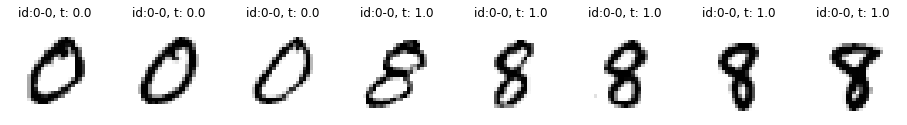

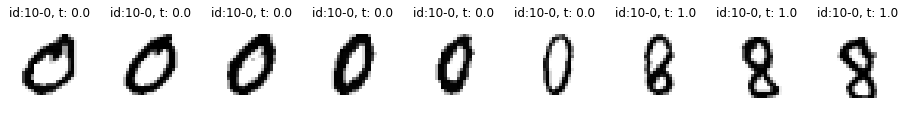

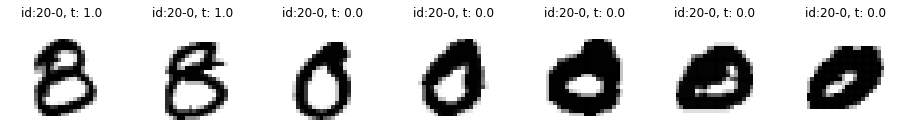

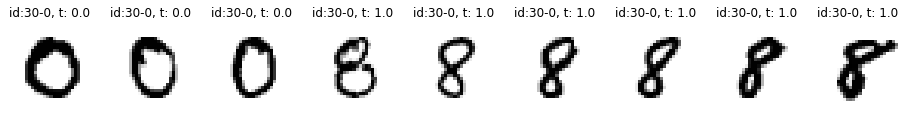

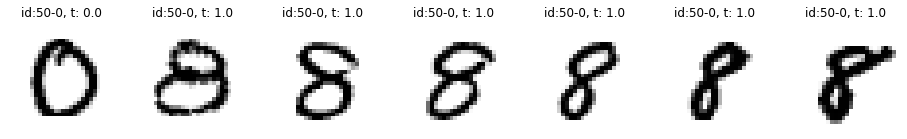

In [22]:
for k in res.keys():
    for k2 in res[k].keys():
        plot_digits(res[k][k2], '-'.join(map(str, [k, k2])))

In [23]:
res

{0: {0: [0, 1376, 1447, 1514, 1217, 1164, 234, 301]},
 10: {0: [10, 355, 674, 724, 1202, 392, 1083, 1903, 406]},
 20: {0: [20, 1654, 1166, 1107, 1117, 174, 160]},
 30: {0: [30, 1493, 1367, 1786, 1319, 981, 1000, 42, 435]},
 50: {0: [50, 1479, 650, 541, 463, 42, 435]}}